<a href="https://colab.research.google.com/github/hectorjimenez12/FONDEF_2023_Debris_Flow/blob/main/01Experimentos/03_Results_FiguresBE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#pip install --force-reinstall -v "scikit-learn==1.5.1"

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
  Obtaining dependency information for scikit-learn==1.5.1 from https://files.pythonhosted.org/packages/f2/60/6c589c91e474721efdcec82ea9cc5c743359e52637e46c364ee5236666ef/scikit_learn-1.5.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for numpy>=1.19.5 from https://files.pythonhosted.org/packages/ac/9c/703d6775b99ae37c3d4fc32984953572fb20e23e61c0f4154f05e5758a30/numpy-2.0.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 746.6 kB/s eta 0:00:00
  Link requires a different Python (3.10.12 not in: '>=3.7,<3.10'): https://files.pythonhosted.org/packages/99/f1/c00d6be56e1a718a3068079e3ec8ce044d7179345280f6a3f5066068af0d/scipy-1.6.2.tar.gz (from https://pypi.org/simple/scipy/) (requires-python:>=3.7,<3.10)
  Link requires a different Python (3.10.12 not in: '>=3.7,<3.10'): https

In [1]:
import os
import numpy as np
import pandas as pd
import pdb
import geopandas as gpd
import copy
import matplotlib.pyplot as plt
import joblib

In [20]:
import sklearn
#from sklearn.metrics import __all__
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
import random
SEED = 4376
random.seed(SEED)
np.random.seed(SEED)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
rootfolderBE = "/content/drive/MyDrive/Investigacion/2024/Otoño/FONDEF_AMTC_Probability_Of_DebrisFlow/01_Entrenamiento_Modelos/agosto2024/BE_cv100/"
fileseedsBE  = os.listdir(rootfolderBE)
seeds = [i.split('ModelResults')[1].split('.pickle')[0] for i in fileseedsBE]

In [10]:
class BFS_model:
    """Initialition"""
    def __init__(self, name, dgrid_values, dmodels, dXscaled, dY, metric_train = 'roc_auc'):
        self.name         = name                                       # name of the model
        self.grid_values  = dgrid_values[self.name]                     # dictionary with hyperparameters
        self.dmodels      = dmodels
        self.model        = copy.deepcopy(dmodels[self.name])          # dictionary with base model
        self.metric_train = metric_train                               # name of the metric use to train

        self.X = dXscaled
        self.Y = dY
        #if train_test_split:
        #    self.X['train'] = pd.concat([self.X['train'],self.X['val']], axis = 0, ignore_index = True)
        #    self.Y['train'] = pd.concat([self.Y['train'],self.Y['val']], axis = 0, ignore_index = True)

        self.RobustScaling()
        self.Oversampling()
        self.features = self.X['features']

        cvmax = np.unique(self.Y['train'],return_counts=True)
        self.grid_model = GridSearchCV(copy.deepcopy(self.model), param_grid = self.grid_values,
                                       cv = 100 , scoring = self.metric_train, n_jobs = 30)

        self.mhf_hystory     = {} # metrics, hyperparameters and features
        self.select_model    = {}
        self.best_metric_model  = 0

    def get_model(self):
        return self.model
    def get_metrics(self):
        return self.metrics_history
    def get_hyperpar(self):
        return self.metrics_history

    def RobustScaling(self):
        scaler = MinMaxScaler()
        self.X['train'] = pd.DataFrame(scaler.fit_transform(self.X['train']) , columns = self.X['train'].columns, index = self.X['train'].index)
        self.X['val']   = pd.DataFrame(scaler.transform(self.X['val'])       , columns = self.X['val'].columns  , index = self.X['val'].index)
        self.X['test']  = pd.DataFrame(scaler.transform(self.X['test'])      , columns = self.X['test'].columns , index = self.X['test'].index)

    def Oversampling(self):
        y_train, X_train = copy.deepcopy(self.Y['train']), copy.deepcopy(self.X['train'])
        vc =  y_train.value_counts(dropna=False)
        index_concat = np.random.choice(a = y_train[y_train['y'].isin([1])].index ,size = int( max(vc) - min(vc) ) ,replace = True)
        y_train = pd.concat([y_train,y_train.loc[index_concat,:]], axis = 0)
        X_train = pd.concat([X_train,X_train.loc[index_concat,:]], axis = 0)
        self.Y['train'], self.Y['val'], self.Y['test'] = np.array(y_train).reshape(-1) , np.array(self.Y['val']).reshape(-1) , np.array(self.Y['test']).reshape(-1)
        self.X['train'], self.X['val'], self.X['test'] = np.array(X_train)             , np.array(self.X['val'])             , np.array(self.X['test'])

    def get_X(self,features_model):
        indexes    = [k for k in range(len( self.features )) if self.features[k] in features_model ]
        return self.X['train'][:,indexes], self.X['val'][:,indexes] ,self.X['test'][:,indexes]

    '''Seleccion de hiperparametros optimos de un modelo con features fijas'''
    def tune_hyper(self, features_train = None):
        grid_model_train = copy.deepcopy(self.grid_model)
        if features_train is None:
            features_train = self.features

        Xtrain_feat, Xval_feat, Xtest_feat = self.get_X(features_train)

        grid_model_train.fit(Xtrain_feat, self.Y['train'] )
        yp_train, ybin_train     = grid_model_train.predict_proba(Xtrain_feat)[:,1], grid_model_train.predict(Xtrain_feat)
        yp_val,  ybin_val        = grid_model_train.predict_proba(Xval_feat)[:,1]  , grid_model_train.predict(Xval_feat)
        yp_test, ybin_test       = grid_model_train.predict_proba(Xtest_feat)[:,1] , grid_model_train.predict(Xtest_feat)

        auc_train, auc_val , auc_test              = roc_auc_score(self.Y['train'], yp_train), roc_auc_score(self.Y['val'], yp_val) , roc_auc_score(self.Y['test'], yp_test)
        dresults = {'cmetrics_train': classification_report(self.Y['train'], ybin_train,output_dict=True),
                    'cmetrics_test': classification_report(self.Y['test'], ybin_test,output_dict=True), 'hyperparams':grid_model_train.best_params_,
                    'train_metric': [auc_train, auc_val , auc_test] ,'features': features_train ,'features_selection': self.features,
                    'model': grid_model_train}
        return dresults

    def get_dictionary_result(self,dresults,feat_del):

      d = {'train_metric':dresults['train_metric'] ,'metrics':dresults['cmetrics_test'],
           'hyperparams': dresults['hyperparams'], 'features':dresults['features'],
           'model':dresults ['model'],'feat_del' :feat_del}
      return d

    ''' Backward selection of features '''
    #ind_sel: indice de seleccion (0 --> training, 1 --> validacion)
    def backward_selection(self, features_train = None, iter = 1, ind_sel = 1, t = 0.05):
        if features_train is None:
            features = self.features
        else:
            features = features_train

        if len(features) == 1:
            return self.mhf_hystory

        if len(features) == len(self.features) :
            res_all_feat = self.tune_hyper(features)

            if isinstance(ind_sel,int):
                self.best_metric_model = res_all_feat['train_metric'][ind_sel]
            else:
                self.best_metric_model = np.mean( [res_all_feat['train_metric'][z] for z in ind_sel] )
            self.mhf_hystory[0] = {**self.get_dictionary_result(res_all_feat,feat_del = ''), **{'type':'init'} }
            self.select_model = {**copy.deepcopy( self.mhf_hystory[0]  ), **{'iter':0} }
            print('all features: ',self.best_metric_model)

        best_improv, best_mhf = 0, None
        for i, feat in enumerate(features):
            train_feats = [k for k in features if k != feat ]
            res_train = self.tune_hyper(train_feats) #use all features

            if isinstance(ind_sel,int):
                auc_val   = res_train['train_metric'][ind_sel]
            else:
                auc_val   =  np.mean( [res_train['train_metric'][z] for z in ind_sel] )

            mhf_dict = self.get_dictionary_result(res_train, feat_del = feat)
            if auc_val > best_improv:
                best_improv = auc_val
                best_mhf    = mhf_dict

        print(iter, best_improv)

        types_previous_models = [j['type'] for j in self.mhf_hystory.values()]

        print(types_previous_models)

        dif = self.best_metric_model - best_improv
        print(dif)

        if best_improv >= self.best_metric_model:
            self.best_metric_model = best_improv
            self.select_model = {**copy.deepcopy(best_mhf), **{'iter':iter} }
            self.mhf_hystory[iter] = {**best_mhf, **{'type':'improv'} }
            print('New best: ',self.best_metric_model)
            return self.backward_selection(features_train = best_mhf['features'] , iter = iter + 1 ,  ind_sel = ind_sel, t = t )
        elif  dif > t or types_previous_models[-1] == 'noimprov' :
            self.mhf_hystory[iter] = {**best_mhf, **{'type':'noimprov'} }
            return self.backward_selection(features_train =best_mhf['features'] , iter = iter + 1 ,  ind_sel = ind_sel, t = t )
        else:
            self.select_model = {**copy.deepcopy(best_mhf), **{'iter':iter} }
            self.mhf_hystory[iter] = {**best_mhf, **{'type':'improv'} }
            return self.backward_selection(features_train = best_mhf['features'] , iter = iter + 1 ,  ind_sel = ind_sel, t = t )

In [11]:
feat_names = {'max_precip':'mpp', 'precip_intensity_tc':'ptc','total_precip':'tpp','soil_moisture_prev':'smp','temp_mean':'tmp','melton_index':'mei','drainage_density':'ddn',
              'mean_slope':'msl','california_tc':'tc', 'area':'ar','main_river_slope':'rsl'}

In [15]:
seeds_BE = []
seeds_fail = []
map_seed_to_result = {}
for k, ifile in enumerate(fileseedsBE):
  try:
    a = joblib.load(rootfolderBE + ifile)
    #strprint = i.split('MultiLayerPerceptron')[1].split('joblib')[0]
    seeds_BE.append( int(seeds[k]) )
    map_seed_to_result[int(seeds[k])] = a
  except:
    print(int(seeds[k]))
    seeds_fail.append(int(seeds[k]))

print(map_seed_to_result)

AttributeError: Can't get attribute '_Scorer' on <module 'sklearn.metrics._scorer' from '/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py'>

# Figuras Paper

Boxplot con AUC y color de puntos igual al numero de features seleccionados

In [13]:
def getplotresults(d):
  test     = [i['train_metric'][2] for i in d.values()]
  training = [i['train_metric'][0] for i in d.values()]
  val      = [i['train_metric'][1] for i in d.values()]

  return [training, val, test]

In [ ]:
def get_select_model(dict_model, ind_sel, treshold):
  tvtmetrics      = getplotresults(dict_model)
  metrics_select  = np.array(tvtmetrics[ind_sel])
  id_max          = np.where(metrics_select == max(metrics_select))[0][-1]
  max_metric      = metrics_select[id_max]
  id_pass_filt    = np.where( max_metric - metrics_select <= treshold )[0]
  id_select       = [i for i in id_pass_filt if i >= id_max][-1]
  features_select = dict_model[id_select]['features']
  return tvtmetrics[2][id_select], features_select, id_select

#get_select_model(restest[model_names[0]][0][1] , ind_sel = 0, treshold = 0 )


In [ ]:
model_names = ['LogisticRegression',#'RandomForest',
               'RandomForest',
               #'KNeighbors',
               #'GaussianNBayes',
               'SupportVectorClassifier',
               'MultiLayerPerceptron']

In [ ]:
seeds_BE = seeds_BE[:50]

In [ ]:
dfboxplot = pd.DataFrame( columns = ['seed','model','auc','nfeatures','type','treshold'] )
dfhist    = pd.DataFrame( columns = ['seed','model','auc_dif','feature'  ,'type','treshold','position'] )
tresholds = [0, 0.02, 0.04]
k = 0

for i, iseed in enumerate(seeds_BE):

    seed_res = joblib.load(rootfolderBE + 'MultiLayerPerceptron' + str(seeds_BE[i]) + 'joblib.pkl' )
    for k, model in enumerate(model_names):
      dict_tt, dict_tvt          = seed_res[model][0][1], seed_res[model][1][1]

      list_auc_featstt  = [ get_select_model(dict_tt  , ind_sel = 0, treshold = 0 ),
                            get_select_model(dict_tt  , ind_sel = 0, treshold = 0.02 ),
                            get_select_model(dict_tt  , ind_sel = 0, treshold = 0.04 )]
      list_auc_featstvt  = [ get_select_model(dict_tvt , ind_sel = 1, treshold = 0 ),
                            get_select_model(dict_tvt , ind_sel = 1, treshold = 0.02 ),
                            get_select_model(dict_tvt , ind_sel = 1, treshold = 0.04 )]

      for j in range(3):
        datatt  = list_auc_featstt[j]
        datatvt = list_auc_featstvt[j]
        dfboxplot.loc[len(dfboxplot)] = [iseed, model, datatt[0], len(datatt[1]),'TT',tresholds[j] ]
        dfboxplot.loc[len(dfboxplot)] = [iseed, model, datatvt[0], len(datatvt[1]),'TVT',tresholds[j] ]

        listTT        = list(dict_tt.values())[datatt[2]:]
        sort_feat_tt  = [z['feat_del'] for z in listTT][1:] + listTT[-1]['features']
        auc_differencesTT  = np.round([listTT[z]['train_metric'][2] - listTT[z+1]['train_metric'][2]  for z in range(0,len(listTT)-1) ],2)*100
        auc_differencesTT  = auc_differencesTT.astype(int)

        listTVT       = list(dict_tvt.values())[datatvt[2]:]
        sort_feat_tvt = [z['feat_del'] for z in listTVT][1:] + listTVT[-1]['features']
        auc_differencesTVT  = np.round([listTVT[z]['train_metric'][2] - listTVT[z+1]['train_metric'][2]  for z in range(0,len(listTVT)-1) ],2)*100
        auc_differencesTVT  = auc_differencesTVT.astype(int)

        max_postt     = len(sort_feat_tt)
        max_postvt    = len(sort_feat_tvt)

        #save features in df for histogram
        for z,ifeat in enumerate(sort_feat_tt):
          if z != len(sort_feat_tt)-1:
            dfhist.loc[len(dfhist)] = [iseed, model, auc_differencesTT[z] , ifeat ,'TT', tresholds[j], max_postt - z ]   #datatt[0]
          else:
            dfhist.loc[len(dfhist)] = [iseed, model, np.nan , ifeat ,'TT', tresholds[j], max_postt - z ]   #datatt[0]
        for z,ifeat in enumerate(sort_feat_tvt):
          if z != len(sort_feat_tvt)-1:
            dfhist.loc[len(dfhist)] = [iseed, model, auc_differencesTVT[z] , ifeat ,'TVT', tresholds[j], max_postvt - z ] # datatvt[0]
          else:
            dfhist.loc[len(dfhist)] = [iseed, model, np.nan , ifeat ,'TVT', tresholds[j], max_postvt - z ] # datatvt[0]

print(dfboxplot)
print(len(np.unique(dfboxplot.seed)))
dfhist.treshold

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use a

          seed                 model       auc  nfeatures type  treshold
0     94958466    LogisticRegression  0.866351          5   TT      0.00
1     94958466    LogisticRegression  0.858664          5  TVT      0.00
2     94958466    LogisticRegression  0.845062          2   TT      0.02
3     94958466    LogisticRegression  0.846245          1  TVT      0.02
4     94958466    LogisticRegression  0.846245          1   TT      0.04
...        ...                   ...       ...        ...  ...       ...
1195  90188262  MultiLayerPerceptron  0.592253          1  TVT      0.00
1196  90188262  MultiLayerPerceptron  0.846245          4   TT      0.02
1197  90188262  MultiLayerPerceptron  0.592253          1  TVT      0.02
1198  90188262  MultiLayerPerceptron  0.840331          3   TT      0.04
1199  90188262  MultiLayerPerceptron  0.592253          1  TVT      0.04

[1200 rows x 6 columns]
50


0       0.00
1       0.00
2       0.00
3       0.00
4       0.00
        ... 
4991    0.02
4992    0.04
4993    0.04
4994    0.04
4995    0.04
Name: treshold, Length: 4996, dtype: float64

<ipython-input-14-ae4e4a971bfe>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


Text(0, 0.5, '# of Features')

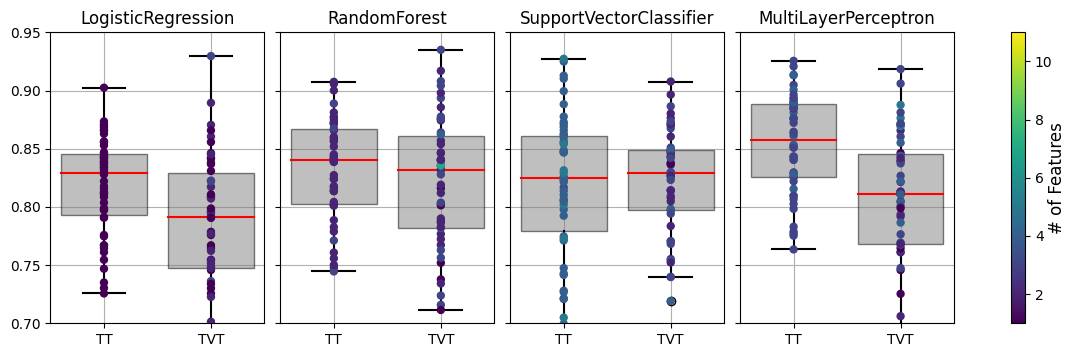

In [ ]:
import matplotlib
short_name_models = ['LR', 'RF', 'GNB','SVC', 'MLP']
%matplotlib inline
dprops = {'color'       :dict(boxes='r', whiskers='r', medians='r', caps='r'),
          'boxprops'    :dict(linestyle='-', linewidth=1,facecolor = "gray", alpha= 0.5),
          'flierprops'  :dict(linestyle='', linewidth=1),
          'medianprops' :dict(linestyle='-', linewidth=1.5,color='red'),
          'whiskerprops':dict(linestyle='-', linewidth=1.5),
          'capprops'    :dict(linestyle='-', linewidth=1.5) }

cm = plt.cm.get_cmap('RdYlBu')

df0 = dfboxplot[ (dfboxplot.treshold == 0.04) ]

fig, ax = plt.subplots(ncols = 4,figsize = (12,4), sharey = True)
plt.subplots_adjust(wspace=0,hspace=0)
for i, model in enumerate(model_names):
  #for k, tresh in enumerate(tresholds):
  dfbox = df0[(df0.model == model)]  #& (dfboxplot.treshold == tresh) ]
  dfbox.boxplot(ax = ax[i] ,column = 'auc', by = 'type', widths = 0.8, patch_artist=True, **dprops )
  dvalues = { 'TT':1,'TVT':2 }
  sc = ax[i].scatter( x = [dvalues[k] for k in dfbox.type]  , y = dfbox.auc , c = dfbox.nfeatures ,vmin = 1, vmax = 11 , s=25, cmap= 'viridis', zorder = 10 )
  ax[i].set_title('')
  ax[i].set_xlabel('')
  ax[i].set_title(model)
plt.ylim([0.7,0.95])
plt.tight_layout()
ax[k].get_figure().suptitle('')
cbar = plt.colorbar(sc, ax=ax[:],shrink = 1)
cbar.ax.set_ylabel('# of Features', rotation=90, labelpad= 10, va="bottom",fontsize=12)


In [ ]:
import matplotlib.pyplot as plt
print(matplotlib.font_manager.get_font_names())
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 15
#plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['font.serif'] = ['Times New Roman']
#matplotlib.rcParams['font.serif'] = ['STIXGeneral']

#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Ubuntu'
#plt.rcParams['font.monospace'] = 'Ubuntu Mono'

plt.rc('font'  , size     =BIGGER_SIZE)          # controls default text sizes
plt.rc('axes'  , titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes'  , labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick' , labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick' , labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize =BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


['STIXSizeThreeSym', 'Liberation Sans', 'STIXGeneral', 'cmex10', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXNonUnicode', 'DejaVu Sans Display', 'Humor Sans', 'DejaVu Sans', 'cmr10', 'DejaVu Serif Display', 'cmb10', 'STIXSizeFiveSym', 'Liberation Mono', 'STIXSizeTwoSym', 'cmsy10', 'cmmi10', 'Liberation Sans Narrow', 'Liberation Serif', 'cmtt10', 'DejaVu Sans Mono', 'cmss10']


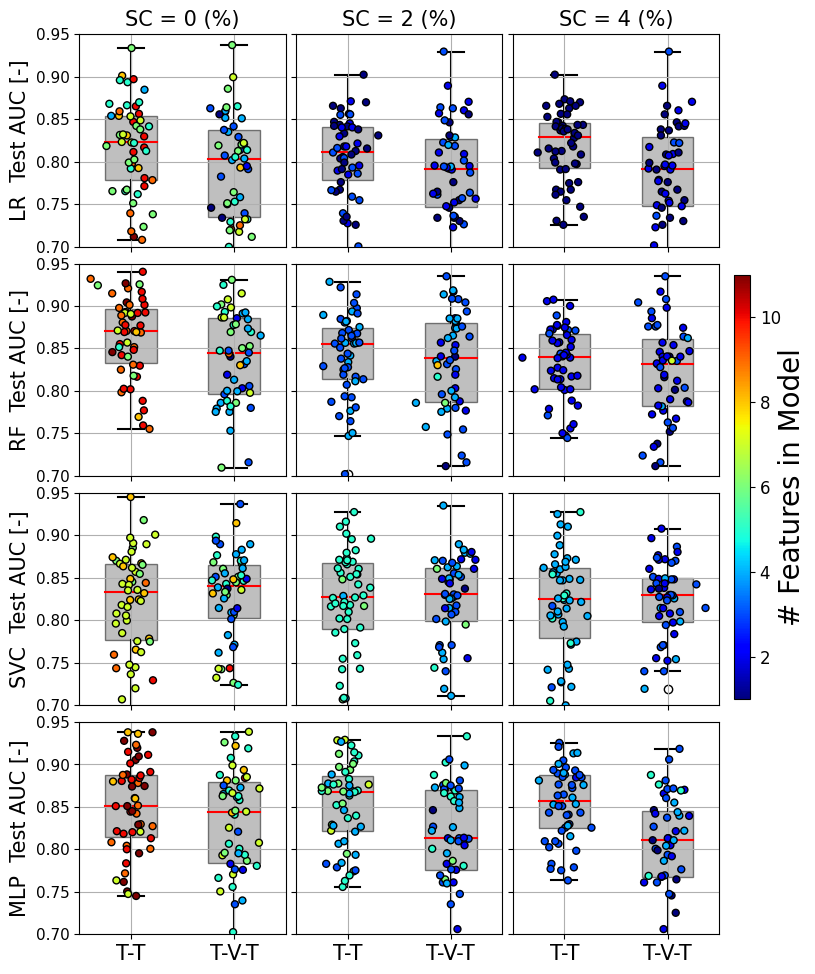

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import font_manager
customFN =  "DejaVu Sans"
fig, ax = plt.subplots(nrows=4,ncols = 3,figsize = (8,12), sharey = True)
model_namesFinal = ['LogisticRegression', 'RandomForest', 'SupportVectorClassifier', 'MultiLayerPerceptron']
for i, model in enumerate(model_namesFinal):
  for k, tresh in enumerate(tresholds):
    dfbox = dfboxplot[ (dfboxplot.model == model) & (dfboxplot.treshold == tresh) ]
    dfbox.boxplot(ax = ax[i,k] ,column = 'auc', by = 'type', widths = 0.1,positions=[1.1, 1.3], zorder=0,patch_artist=True ,**dprops )
    dvalues = { 'TT':1.1,'TVT':1.3 }

    xpoints = np.array([dvalues[k] for k in dfbox.type])
    noise = np.random.normal(0,0.02,size = len(xpoints))

    sc = ax[i,k].scatter( x =  xpoints + noise , y = dfbox.auc , c = dfbox.nfeatures ,
                     vmin = 1, vmax = 11 , s=25, cmap= 'jet',zorder=5, edgecolor = 'black' )

    ax[i,k].set_xlabel('')
    ax[i,k].set_xlim([1,1.4])
    if k == 0:
      ax[i,k].set_ylabel(  ['LR', 'RF', 'SVC', 'MLP'][i] + ' ' + ' Test AUC [-]', fontsize = 15, fontname = customFN)
    if i == 0:
      ax[i,k].set_title( 'SC = ' + str([0,2,4][k]) + ' (%)' , fontname = customFN )
    else:
      ax[i,k].set_title( '' )
    if i != 3:
      ax[i,k].set_xticks([1.1,1.3], ['',''])
    else:
      ax[i,k].set_xticks([1.1,1.3], ['T-T','T-V-T'], fontname = customFN)

    yticks_font = font_manager.FontProperties(family=customFN,size=11)
    for tick in ax[i,k].get_yticklabels():
      tick.set_fontproperties(yticks_font)


plt.ylim([0.7,0.95])
ax[i,k].get_figure().suptitle('')
axins = inset_axes(
    ax[1,-1],
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower right",
    bbox_to_anchor=(-0.25, - 1.15, 1.5, 4),
    bbox_transform=ax[1,-1].transAxes,
    borderpad=1,
)
cbar = fig.colorbar(sc, cax= axins )
cbar.ax.set_ylabel('# Features in Model', fontname = customFN, rotation=90, labelpad= 18, va="bottom",fontsize=20)

plt.subplots_adjust(wspace=0.05,hspace=0.08)

plt.savefig('Fig_BE.pdf',dpi=1500, bbox_inches = 'tight')

# Histograma

In [ ]:
def unique_no_sort(v):
  Vunique                = np.unique(v,return_index=True)
  Vunique_nosorted       = [ v[i] for i in sorted(Vunique[1]) ]
  return Vunique_nosorted



unique_no_sort([1,2,34,5,3,2,1,4,5,9,3,2,1,7])

[1, 2, 34, 5, 3, 4, 9, 7]

In [ ]:
#dfplot = dfhist[(dfhist.model == "LogisticRegression") & (dfhist.treshold == 0.05)].loc[:,['feature','type']]

#feats      = [ifeat[0] for ifeat in dfplot.value_counts().index]
#featunique = unique_no_sort(feats)
#dmap       = {feat:float(i) for i,feat in enumerate(featunique) }

#df = copy.deepcopy(dfplot)
#df.feature = [dmap[feat] for feat in df.feature]

#fig, ax = plt.subplots(nrows=2,ncols = 2,figsize = (8,12), sharey = True)
#dftt, dftvt = dfplot[dfplot.type == 'TT'], dfplot[dfplot.type == 'TVT']
#dftvt['sort'] = [dmap[feat] for feat in dftvt.feature]
#ax[0,0].hist(dftt.feature.values, bins= [0,1] ,range = [0,len(dmap)], color='blue', alpha=0.35,label='TT',align='mid') #edgecolor='black'
#counts, bins, bars = ax[0,0].hist(dftvt.sort_values(by = 'sort' ,axis=0).feature.values, bins = [ i for i in range(len(dmap)+1) ]  ,
#             color='green',alpha=0.35,label='TVT',rwidth=1,align='mid',zorder=20) #len(np.unique(dftvt.feature.values))
#ax[0,0].set_xticks( [ i+0.5 for i in range(len(dmap)) ] , labels = [feat_names[i] for i in dmap.keys()] ,rotation = 90)
#ax[0,0].legend()
#plt.tight_layout()

<ipython-input-18-87899e49f256>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftvt.loc[:,'sort'] = [dmaptvt[feat] for feat in dftvt.feature]
<ipython-input-18-87899e49f256>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dftt.loc[:,'sort']  = [dmaptt[feat] for feat in dftt.feature]
<ipython-input-18-87899e49f256>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

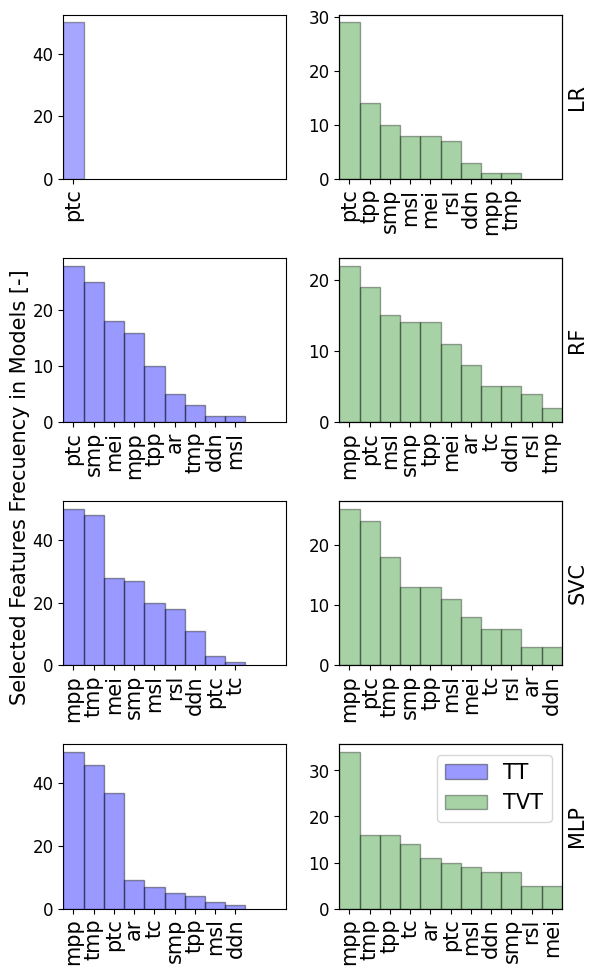

In [ ]:
import matplotlib.patches as mpatches
#tt_patch = mpatches.Patch(color='red', label='The red data')
#tvt_patch = mpatches.Patch(color='red', label='The red data')


fig, axes = plt.subplots(nrows = 4,ncols = 2,figsize = (6,10))
model_namesFinal = ['LogisticRegression', 'RandomForest', 'SupportVectorClassifier', 'MultiLayerPerceptron']
for k, model in enumerate(model_namesFinal):
  dfplot = dfhist[(dfhist.model == model) & (dfhist.treshold == 0.04)].loc[:,['feature','type']]
  dftt, dftvt = dfplot[dfplot.type == 'TT'], dfplot[dfplot.type == 'TVT']

  featstt, featstvt           = [ifeat[0] for ifeat in dftt.value_counts().index], [ifeat[0] for ifeat in dftvt.value_counts().index]
  featuniquett, featuniquetvt = unique_no_sort(featstt),unique_no_sort(featstvt)
  dmaptt, dmaptvt             = {feat:float(i) for i,feat in enumerate(featuniquett) }, {feat:float(i) for i,feat in enumerate(featuniquetvt) }

  dftvt.loc[:,'sort'] = [dmaptvt[feat] for feat in dftvt.feature]
  dftt.loc[:,'sort']  = [dmaptt[feat] for feat in dftt.feature]

  dfttsort  = dftt.sort_values(by = 'sort' ,axis=0)
  dftvtsort = dftvt.sort_values(by = 'sort' ,axis=0)

  tvthist = counts, bins, bars = axes[k,1].hist(dftvtsort.feature.values  ,bins = [ i for i in range(len(dmaptvt)+1) ] , edgecolor='black', color='green', alpha=0.35, label='TVT', rwidth=1, align='mid', zorder=20)
  if len(dmaptt) == 1:
    axes[k,0].hist(dfttsort.feature.values, color='blue', bins = [0,1], alpha=0.35, label='TT', align='mid', edgecolor='black')
  else:
    tthist = axes[k,0].hist(dfttsort.feature.values  ,bins = [ i for i in range(len(dmaptt)+1) ] , edgecolor='black', color='blue', alpha=0.4, label='TT', rwidth=1, align='mid', zorder=20)

  axes[k,1].set_xticks( [ i+0.5 for i in range(len(dmaptvt)) ] , labels = [feat_names[i] for i in dmaptvt.keys()] ,rotation = 90)
  axes[k,0].set_xticks( [ i+0.5 for i in range(len(dmaptt)) ] , labels = [feat_names[i] for i in dmaptt.keys()] ,rotation = 90)

  axes[k,0].set_xlim([0,11])
  axes[k,1].set_xlim([0,11])
  ax2 = axes[k,1].twinx()
  ax2.set_yticks([])
  ax2.set_ylabel(['LR', 'RF', 'SVC', 'MLP'][k])

axes[k,1].legend(handles = [tthist[2],tvthist[2]], labels=['TT','TVT'])
plt.tight_layout()
fig.text(0, 0.5, 'Selected Features Frecuency in Models [-]', va='center', rotation='vertical')
#plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('Fig_BE_Hist.pdf',dpi=1500, bbox_inches = 'tight')

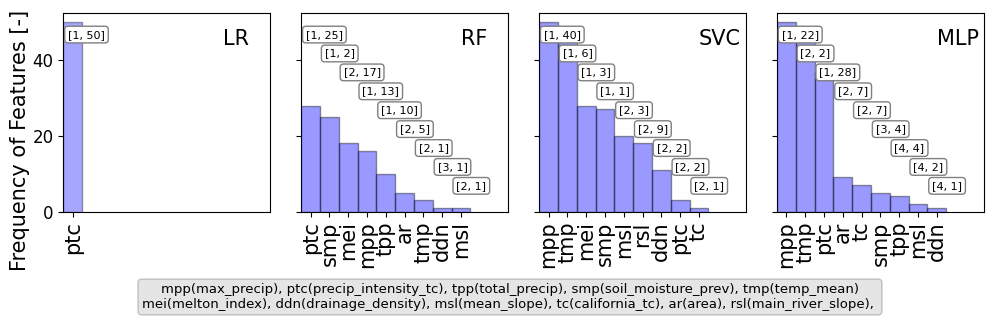

In [ ]:
import matplotlib.patches as mpatches
import matplotlib as mpl
#tt_patch = mpatches.Patch(color='red', label='The red data')
#tvt_patch = mpatches.Patch(color='red', label='The red data')
#minbin = 0.
#maxbin = 1.
#nbins = 20
#bins = np.linspace(minbin,maxbin,20)
#cmap = plt.get_cmap('jet')
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
#colors = cmap(bins)

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=1) #rotation='vertical'

fig, axes = plt.subplots(nrows = 1,ncols = 4,figsize = (10,3),sharey=True)
for k, model in enumerate(model_names):
  dfplot      = dfhist[(dfhist.model == model) & (dfhist.treshold == 0.04)]

  dftt, dftvt = dfplot[dfplot.type == 'TT'].loc[:,['feature','type']], dfplot[dfplot.type == 'TVT'].loc[:,['feature','type']]

  featstt, featstvt           = [ifeat[0] for ifeat in dftt.value_counts().index], [ifeat[0] for ifeat in dftvt.value_counts().index]
  featuniquett, featuniquetvt = unique_no_sort(featstt),unique_no_sort(featstvt)
  dmaptt, dmaptvt             = {feat:float(i) for i,feat in enumerate(featuniquett) }, {feat:float(i) for i,feat in enumerate(featuniquetvt) }

  dftvt.loc[:,'sort'] = [dmaptvt[feat] for feat in dftvt.feature]
  dftt.loc[:,'sort']  = [dmaptt[feat] for feat in dftt.feature]

  dfttsort  = dftt.sort_values(by = 'sort' ,axis=0)
  dftvtsort = dftvt.sort_values(by = 'sort' ,axis=0)

  #histograms
  #counts, bins, bars = axes[k,1].hist(dftvtsort.feature.values  ,bins = [ i for i in range(len(dmaptvt)+1) ] , edgecolor='black', color='green', alpha=0.4, label='TVT', rwidth=1, align='mid', zorder=20)
  if len(dmaptt) == 1:
    edges, bin, patches = axes[k].hist(dfttsort.feature.values, color='blue', bins = [0,1], alpha=0.35, label='TT', align='mid', edgecolor='black')
  else:
    edges, bin, patches = axes[k].hist(dfttsort.feature.values  ,bins = [ i for i in range(len(dmaptt)+1) ] , edgecolor='black', color='blue', alpha=0.4, label='TT', rwidth=1, align='mid', zorder=20)

  aucs_tt, pos_tt, aucs_tvt, pos_tvt = [], [], [], []
  #text
  for j, p in enumerate(patches):
    feature = list(dmaptt.keys())[j]
    df_auc_position = dfplot[(dfplot.type == 'TT') & (dfplot.feature == feature)].loc[:,['feature','position','auc_dif']]
    aucs_tt.append(np.mean(df_auc_position.auc_dif))
    pos_counts = np.unique(df_auc_position.position,return_counts=True)

    pos_tt.append( [pos_counts[0][0],pos_counts[1][0]] )
  #text
  #for j, p in enumerate(bars):
  #  feature = list(dmaptvt.keys())[j]
  #  df_auc_position = dfplot[(dfplot.type == 'TVT') & (dfplot.feature == feature)].loc[:,['feature','position','auc']]
  #  aucs_tvt.append(np.mean(df_auc_position.auc))
  #  pos_tvt.append(int(np.mean(df_auc_position.position)))

  #axes[k,1].set_xticks( [ i+0.5 for i in range(len(dmaptvt)) ] , labels = [ feat_names[i] for i in dmaptvt.keys()] ,rotation = 90)
  axes[k].set_xticks( [ i+0.5 for i in range(len(dmaptt)) ] , labels = [feat_names[i] for i in dmaptt.keys()] ,rotation = 90)

  axes[k].set_xlim([0,11])
  #ax1 = axes[k].twinx()
  #ax1.set_ylim(-20,+20)
  #ax1.set_yticks([])
  #ax1.scatter(x=[ i+0.5 for i in range(len(dmaptt)) ],y = aucs_tt,marker='*',color='red')

  #ax2 = axes[k,1].twinx()
  #ax2.scatter([ i+0.5 for i in range(len(dmaptvt)) ],y = aucs_tvt,marker='*',color='red')
  #ax2.set_ylim(0.7,0.95)
  #
  #ax1.set_ylabel(['LR', 'RF', 'SVC', 'MLP'][k] + ' Loss AUC (%)' )
  #for z in range(len(bars)):
  #  axes[k,1].text (z+0.25, 42 , str(pos_tvt[z]), size = 10 ,bbox=bbox_props)

  for z in range(len(patches)):
    axes[k].text (z+0.25, 46 - 5*z , str(pos_tt[z]), size = 8,zorder = 20 ,bbox=bbox_props)
  axes[k].text (8.5, 44  , ['LR', 'RF', 'SVC', 'MLP'][k] , size = 15)

t = ""
k = 0
for letter,predictor in zip(feat_names.values(),feat_names.keys()):
  if k == 4:
    t = t + letter + '(' + predictor + ')\n'
  else:
    t = t  + letter + '(' + predictor + '), '
  k += 1
props_gray   = dict(boxstyle='round', facecolor='gray', alpha=0.2)
fig.text(0.5, 0.025, t, fontsize= 9.5, ha="center", verticalalignment="top", bbox=props_gray)

#axes[k,1].legend(handles = [tthist[2],bars], labels=['TT','TVT'])
plt.tight_layout()

fig.text(0, 0.5, 'Frequency of Features [-]', va='center', rotation='vertical')
#plt.subplots_adjust(hspace=0.05,wspace=0.05)
plt.savefig('Fig_BE_Hist.pdf',dpi=1500, bbox_inches = 'tight')

#Permutation Importance

In [ ]:
def Pimportance(model,features,Xvalues,columns,best_auc,ytruetest):
  if len(features)==1:
    return [ features , [1] ]
  indexes    = [k for k in range(len( columns )) if columns[k] in features ]
  Xtest_Normal   = Xvalues['test'][:,indexes]

  auc_dif = []
  for i,id_feat in enumerate(indexes):
    Xtest_Shuffled = copy.deepcopy(Xtest_Normal)
    np.random.shuffle(Xtest_Shuffled[:,i])
    yp_test       = model.predict_proba(Xtest_Shuffled)[:,1]
    auc_shuffled  = roc_auc_score(ytruetest, yp_test)
    auc_dif.append( best_auc - auc_shuffled )

  return( [ [columns[k] for k in indexes] , auc_dif ] )


In [ ]:
dprops = {'color'       :dict(boxes='r', whiskers='r', medians='r', caps='r'),
          'boxprops'    :dict(linestyle='-', linewidth=1,facecolor = "gray", alpha= 0.5),
          'flierprops'  :dict(linestyle='', linewidth=1),
          'medianprops' :dict(linestyle='-', linewidth=1.5,color='red'),
          'whiskerprops':dict(linestyle='-', linewidth=1.5),
          'capprops'    :dict(linestyle='-', linewidth=1.5) }

cm = plt.cm.get_cmap('RdYlBu')

<ipython-input-53-b3956eb63aef>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


In [ ]:
dfboxplot = pd.DataFrame( columns = ['seed','model','auc_dif','feature','type','treshold'] )
tresholds = [0, 0.02, 0.04]
k = 0

for i, iseed in enumerate(seeds_BE):
    seed_res = joblib.load(rootfolderBE + 'MultiLayerPerceptron' + str(seeds_BE[i]) + 'joblib.pkl' )
    for k, model in enumerate(model_names):

      #model = model_names[0]
      dict_tt , dict_tvt          = seed_res[model][0][1], seed_res[model][1][1]
      class_tt, class_tvt          = seed_res[model][0][0], seed_res[model][1][0]

      Xvalues   = class_tt.X
      columns   = Xvalues['features']
      ytruetest = class_tt.Y['test']

      list_auc_featstt  = [ get_select_model(dict_tt  , ind_sel = 0, treshold = 0 ),
                            get_select_model(dict_tt  , ind_sel = 0, treshold = 0.02 ),
                            get_select_model(dict_tt  , ind_sel = 0, treshold = 0.04 )]
      list_auc_featstvt  = [ get_select_model(dict_tvt , ind_sel = 1, treshold = 0 ),
                            get_select_model(dict_tvt , ind_sel = 1, treshold = 0.02 ),
                            get_select_model(dict_tvt , ind_sel = 1, treshold = 0.04 )]

      for j in range(3):
        datatt, datatvt  = list_auc_featstt[j], list_auc_featstvt[j]

        modeltt, modeltvt  = list(dict_tt.values())[datatt[2]]['model'], list(dict_tvt.values())[datatvt[2]]['model']

        featstt, featstvt  = list(dict_tt.values())[datatt[2]]['features'], list(dict_tvt.values())[datatvt[2]]['features']

        best_auctt, best_auctvt = datatt[0], datatvt[0]

        pinp_tt  = Pimportance(model = modeltt , features = featstt ,Xvalues = Xvalues, columns = columns, best_auc = best_auctt, ytruetest =ytruetest)
        pinp_tvt = Pimportance(model = modeltvt, features = featstvt,Xvalues = Xvalues, columns = columns, best_auc = best_auctvt, ytruetest =ytruetest)

        for z,ifeat in enumerate( pinp_tt[0] ):
          dfboxplot.loc[len(dfboxplot)] = [iseed, model, pinp_tt[1][z], pinp_tt[0][z] ,'TT',tresholds[j] ]
        for z,ifeat in enumerate(pinp_tvt[0]):
          dfboxplot.loc[len(dfboxplot)] = [iseed, model, pinp_tvt[1][z], pinp_tvt[0][z] ,'TVT',tresholds[j] ]


<ipython-input-142-c687ff8aca2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbox['feat'] = [feat_names[k] for k in dfbox.feature]
<ipython-input-142-c687ff8aca2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfbox['feat'] = [feat_names[k] for k in dfbox.feature]
<ipython-input-142-c687ff8aca2c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

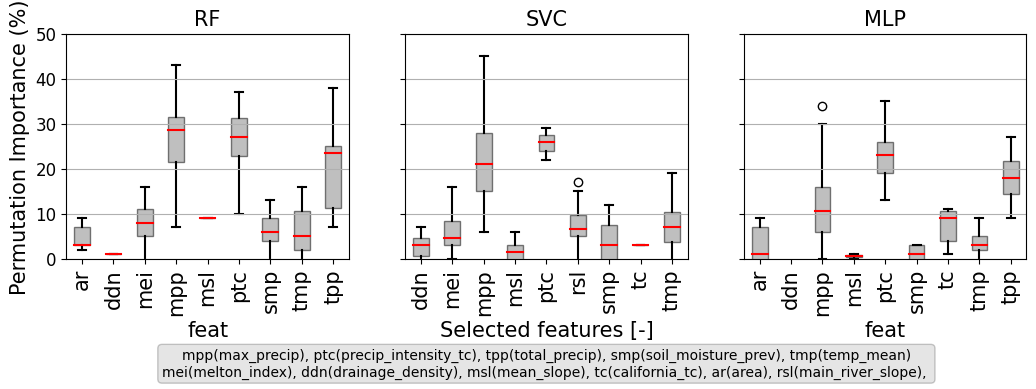

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols = 3,figsize = (12,3), sharey = True)
model_namesFinal = ['LogisticRegression', 'RandomForest', 'SupportVectorClassifier', 'MultiLayerPerceptron']

for i, model in enumerate(model_namesFinal[1:]):
  #for k, tresh in enumerate(tresholds):
    #model = model_namesFinal[0]
    dfbox = dfboxplot[ (dfboxplot.model == model) & (dfboxplot.type == 'TT') & (dfboxplot.treshold == 0.04) ]
    dfbox['feat'] = [feat_names[k] for k in dfbox.feature]
    dfbox = dfbox.sort_values(by = 'feat', axis = 0)
    dfbox['perc'] = np.round(dfbox.auc_dif*100)
    dfbox.boxplot(ax = ax[i] ,column = 'perc', by = 'feat', widths = 0.5, zorder=0, rot = 90,patch_artist=True ,**dprops )
    ax[i].grid(axis = 'x')

    ax[i].set_title( ['RF', 'SVC', 'MLP'][i] )
    if i == 1:
      ax[i].set_xlabel('Selected features [-]')
    ax[i].set_ylim(0,50)

    if i == 0:
      ax[i].set_ylabel(  'Permutation Importance (%)', fontsize = 15, fontname = customFN)

ax[i].get_figure().suptitle('')
fig.text(0.5, -0.15, t, fontsize= 10, ha="center", verticalalignment="top", bbox=props_gray)
#plt.tight_layout()
plt.savefig('PI.pdf',dpi=1500, bbox_inches = 'tight')